# Hands On - Aprendizado Federado aplicado à Internet das Coisas

**Notebook 3**: Configuração do servidor no ambiente federado

### Configurando o servidor

Uma vez escolhido como será realizado o processo de orquestramento de aprendizado, também podemos definir os seguintes parâmetros: 

* Percentual de clientes que deverão estar disponíveis para o treinamento e avaliação do modelo, assim como também o
número mínimo de clientes necessários. 

* Definir o processo de treinamento e avaliação do modelo 

* Realizar a configuração dos parâmetros iniciais do modelo global

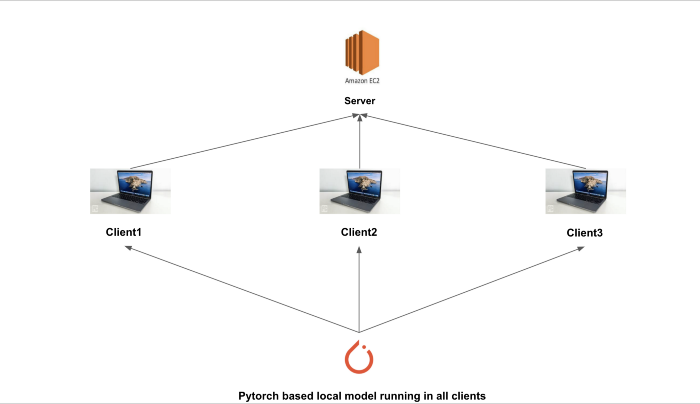

Aqui apenas definiremos manualmente a função de avaliação do nosso modelo.
Uma vez que estamos seguindo uma proposta cliente-servidor, é de extrema importância saber como se comporta a acurácia do servidor central e não apenas as métricas individuais dos clientes. 
Como o framework flower não possui por padrão a implementação de métricas importantes para entender a convergência do servidor, implementamos manualmente.

In [1]:
import torch
import aux

DATA_ROOT = "./data/pml-training.csv"

def test(model, test_loader, device: torch.device = torch.device("cpu")):
    model.eval()
    
    test_loss: float = 0
    correct: int = 0
    num_test_samples: int = 0

    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            num_test_samples += len(data)
            output = model(data.unsqueeze(1).permute(0, 2, 1))
            test_loss += criterion(output, target).item() 
            pred = output.argmax(dim = 1, keepdim = True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= num_test_samples

    return (test_loss, {"accuracy": correct / num_test_samples})

def eval(w):
    train_loader, test_loader = aux.load_data(
        data_root = DATA_ROOT,
        train_batch_size = 64,
        test_batch_size = 4,
        cid = 2,
        nb_clients = 3,
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    server = aux.FlowerClient(
        cid = 999,
        train_loader = train_loader,
        test_loader = test_loader,
        epochs = 1,
        device = device
    )
    server.set_weights(w)
    return test(server.model, train_loader, device)

### Definindo a estratégia de agregação 

Flower permite que o usuário personalize o processo de aprendizagem de acordo com a sua aplicação através da abstração chamada **Strategy**. 
Existem três maneiras de personalizar a maneira como Flower orquestra o processo de aprendizagem no servidor: 

* Usando uma estratégia já existente, como por exemplo o *FedAvg*; 

* Personalizando uma estratégia já existente; 

* Implementando uma nova estratégia do zero. 

O Flower contém uma série de estratégias de aprendizado federado já integradas, logo optamos pelo uso de uma delas, o algoritmo de média federada, como orquestrador de atualização do modelo.

In [2]:
import flwr as fl

strategy = fl.server.strategy.FedAvg(eval_fn = eval)

### Inicializando o servidor



In [3]:
server_address = "[::]:8081"
fl.server.start_server(server_address, config = {"num_rounds": 10}, strategy = strategy)

INFO flower 2021-08-19 22:45:03,721 | app.py:73 | Flower server running (insecure, 10 rounds)
INFO flower 2021-08-19 22:45:03,721 | server.py:118 | Getting initial parameters
INFO flower 2021-08-19 22:45:10,817 | server.py:306 | Received initial parameters from one random client
INFO flower 2021-08-19 22:45:10,817 | server.py:120 | Evaluating initial parameters
INFO flower 2021-08-19 22:45:11,967 | server.py:123 | initial parameters (loss, other metrics): 0.030990796789116815, {'accuracy': 0.21590214067278288}
INFO flower 2021-08-19 22:45:11,968 | server.py:133 | FL starting
DEBUG flower 2021-08-19 22:45:11,969 | server.py:251 | fit_round: strategy sampled 2 clients (out of 2)
DEBUG flower 2021-08-19 22:45:17,563 | server.py:260 | fit_round received 2 results and 0 failures
INFO flower 2021-08-19 22:45:18,544 | server.py:148 | fit progress: (1, 0.019996409004252255, {'accuracy': 0.4649847094801223}, 6.575160046006204)
INFO flower 2021-08-19 22:45:18,545 | server.py:199 | evaluate_round

Com os resultados obtidos pelo modelo federado proposto observamos que em pouquíssimas rodadas conseguimos alcançar uma acurácia similar ao modelo centralizado (neste experimento, apenas em 10 épocas). No entanto, com o uso do modelo federado conseguimos construir de um sistema mais seguro e que forneça uma garantia maior quanto a privacidade do usuário.